In [91]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, ConvLSTM2D, Flatten, Conv1D, Attention, Input
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import backend as K

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
tweetData = pd.read_csv('featureEngineeredFinal.csv', index_col=False)
tweetData

,Unnamed: 0,Unnamed: 0.1,tweet,tweettype,charCount,wordCount,sentenceCount,capCharCount,capWordCount,quotedWordCount,stopwordCount,uniqueWordCount,hashCount,mentionCount,avgWordLen,modTweet,! count,""" count",# count,$ count,% count,& count,' count,( count,) count,* count,+ count,", count",- count,. count,/ count,: count,; count,< count,= count,> count,? count,@ count,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,lemmatizedText
0,0,0,@ZubairSabirPTI pls dont insult the word 'Molna',anger,49,7,1,6,0,0,1,7,0,0,7.000000,pls dont insult the word 'molna',0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pls dont insult word
1,1,1,@ArcticFantasy I would have almost took offens...,anger,81,14,1,4,2,0,5,13,0,0,5.785714,would have almost took offense to this if actu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,would almost take offense actually snap
2,2,2,@IllinoisLoyalty that Rutgers game was an abom...,anger,114,20,3,6,0,0,8,20,0,0,5.700000,that rutgers game was an abomination an affron...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rutgers game abomination affront god man must ...
3,3,3,@CozanGaming that's what lisa asked before she...,anger,90,16,2,3,1,0,7,16,0,0,5.625000,that's what lisa asked before she started ragi...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lisa ask start rag call heh
4,4,4,Sometimes I get mad over something so minuscul...,anger,133,25,1,3,2,0,7,22,0,0,5.320000,sometimes get mad over something so minuscule ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sometimes get mad something minuscule try ruin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43955,43955,43955,@JohnLloydTaylor,neutral,16,1,1,3,0,0,0,1,0,0,16.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
43956,43956,43956,Happy Mothers Day All my love,love,30,6,1,4,0,0,1,6,0,0,5.000000,happy mothers day all my love,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy mother day love
43957,43957,43957,Happy Mother's Day to all the mommies out ther...,love,123,25,1,3,0,0,15,23,0,0,4.920000,happy mother's day to all the mommies out ther...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy mother day mommy woman man long someone day
43958,43958,43958,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,joy,122,19,5,83,18,0,0,19,0,0,6.421053,wassup beautiful follow me peep out my new hit...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wassup beautiful follow peep new hit single ww...


In [31]:
labels = np.array(tweetData['tweettype'])
y = []
for i in range(len(labels)):
    if labels[i] == 'sadness':
        y.append(0)
    elif labels[i] == 'neutral':
        y.append(1)
    elif labels[i] == 'joy':
        y.append(2)
    elif labels[i] == 'love':
        y.append(3)
    elif labels[i] == 'enthusiasm':
        y.append(4)
    elif labels[i] == 'anger':
        y.append(5)
    elif labels[i] == 'surprise':
        y.append(6)
    elif labels[i] == 'relief':
        y.append(7)
    elif labels[i] == 'fear':
        y.append(8)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 9, dtype="float32")
del y

In [32]:
def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join( [w for w in tweetMod.split() if len(w)>1] )
    
    return tweetMod

# Process for all tweets
tweetData['modTweet'] = [featureEngineering(tweet) for tweet in tweetData['tweet']]

In [33]:
def lemmatizeTweet(tweet):
  words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
  # Remove stop words
  stop = set(stopwords.words('english'))
  words = [word for word in words if (word not in stop)]
  # Lemmatize words (first noun, then verb)
  wnl = nltk.stem.WordNetLemmatizer()
  lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
  return " ".join(lemmatized)

tweetData['lemmatizedText'] = tweetData["modTweet"].apply(lambda x:lemmatizeTweet(x))

In [34]:
tokenizer = Tokenizer(num_words=27608, split=' ')
tokenizer.fit_on_texts(tweetData['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(tweetData['lemmatizedText'].values)
X = pad_sequences(X)
    
X_train, X_test, Y_train, Y_test = train_test_split(X,labels, test_size = 0.3, random_state = 42)

In [18]:
embed_dim = 64
keras.backend.clear_session()
model_dropout = Sequential()
model_dropout.add(Embedding(27608,embed_dim,input_length = X.shape[1]))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(1, activation='softmax'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            1766912   
                                                                 
 dropout (Dropout)           (None, 28, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 28, 256)          197632    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 28, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 9)                 2

In [20]:
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 36s 49ms/step - loss: 1.7451 - accuracy: 0.3825 - val_loss: 1.6022 - val_accuracy: 0.4368
Epoch 2/20
481/481 [==============================] - 22s 46ms/step - loss: 1.4852 - accuracy: 0.4901 - val_loss: 1.5641 - val_accuracy: 0.4619
Epoch 3/20
481/481 [==============================] - 21s 44ms/step - loss: 1.3129 - accuracy: 0.5556 - val_loss: 1.5807 - val_accuracy: 0.4591
Epoch 4/20
481/481 [==============================] - 21s 44ms/step - loss: 1.1665 - accuracy: 0.6080 - val_loss: 1.6550 - val_accuracy: 0.4397
Epoch 5/20
481/481 [==============================] - 20s 42ms/step - loss: 1.0455 - accuracy: 0.6534 - val_loss: 1.7232 - val_accuracy: 0.4362
Epoch 6/20
481/481 [==============================] - 20s 42ms/step - loss: 0.9402 - accuracy: 0.6899 - val_loss: 1.8675 - val_accuracy: 0.4220
Epoch 7/20
481/481 [==============================] - 24s 49ms/step - loss: 0.8559 - accuracy: 0.7163 - val_loss: 1.9313 - val_accuracy:

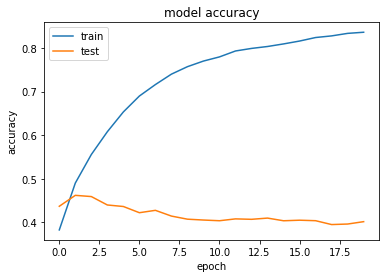

In [23]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('1b_accuracies.png')

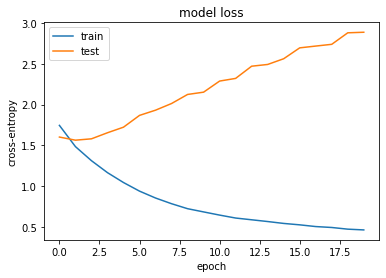

In [24]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('1c_losses.png')

In [36]:
embed_dim = 64
keras.backend.clear_session()
model_dropout = Sequential()
model_dropout.add(Embedding(2000,embed_dim,input_length = X.shape[1]))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(9, activation='softmax'))
model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            128000    
                                                                 
 dropout (Dropout)           (None, 28, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 9)                 2313      
                                                                 
Total params: 327,945
Trainable params: 327,945
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 17s 27ms/step - loss: 1.7560 - accuracy: 0.3839 - val_loss: 1.6266 - val_accuracy: 0.4312
Epoch 2/20
481/481 [==============================] - 12s 24ms/step - loss: 1.5601 - accuracy: 0.4626 - val_loss: 1.5659 - val_accuracy: 0.4564
Epoch 3/20
481/481 [==============================] - 12s 25ms/step - loss: 1.4956 - accuracy: 0.4873 - val_loss: 1.5412 - val_accuracy: 0.4663
Epoch 4/20
481/481 [==============================] - 12s 24ms/step - loss: 1.4602 - accuracy: 0.4946 - val_loss: 1.5327 - val_accuracy: 0.4672
Epoch 5/20
481/481 [==============================] - 12s 24ms/step - loss: 1.4358 - accuracy: 0.5037 - val_loss: 1.5379 - val_accuracy: 0.4629
Epoch 6/20
481/481 [==============================] - 12s 24ms/step - loss: 1.4109 - accuracy: 0.5072 - val_loss: 1.5419 - val_accuracy: 0.4656
Epoch 7/20
481/481 [==============================] - 12s 24ms/step - loss: 1.3846 - accuracy: 0.5147 - val_loss: 1.5465 - val_accuracy:

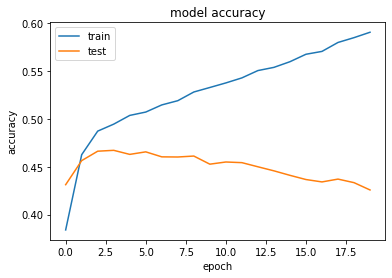

In [39]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('2b_accuracies.png')

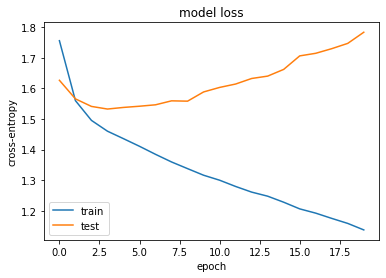

In [40]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('2c_losses.png')

In [60]:
keras.backend.clear_session()

model_dropout = Sequential()
model_dropout.add(Embedding(128,embed_dim,input_length = X.shape[1]))
model_dropout.add(Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same'))
model_dropout.add(LSTM(units=128, return_sequences=False))
model_dropout.add(Dense(9, activation='softmax'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            8192      
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            16416     
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 108,201
Trainable params: 108,201
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 36s 19ms/step - loss: 1.7931 - accuracy: 0.3698 - val_loss: 1.7390 - val_accuracy: 0.3885
Epoch 2/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7313 - accuracy: 0.3957 - val_loss: 1.7204 - val_accuracy: 0.3944
Epoch 3/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7130 - accuracy: 0.3996 - val_loss: 1.7044 - val_accuracy: 0.3979
Epoch 4/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7030 - accuracy: 0.4012 - val_loss: 1.7033 - val_accuracy: 0.3979
Epoch 5/20
481/481 [==============================] - 8s 17ms/step - loss: 1.6965 - accuracy: 0.4049 - val_loss: 1.6989 - val_accuracy: 0.4025
Epoch 6/20
481/481 [==============================] - 8s 17ms/step - loss: 1.6906 - accuracy: 0.4036 - val_loss: 1.7027 - val_accuracy: 0.3971
Epoch 7/20
481/481 [==============================] - 8s 17ms/step - loss: 1.6850 - accuracy: 0.4065 - val_loss: 1.6982 - val_accuracy: 0.400

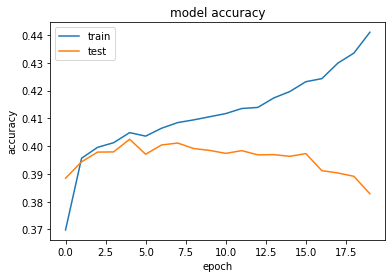

In [63]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('3b_accuracies.png')

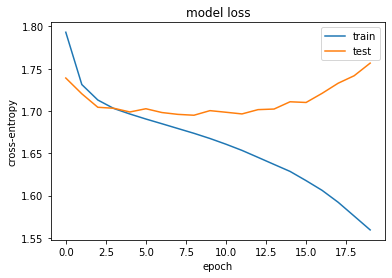

In [64]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('3c_losses.png')

In [65]:
keras.backend.clear_session()

model_dropout = Sequential()
model_dropout.add(Embedding(128,embed_dim,input_length = X.shape[1]))
model_dropout.add(Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same'))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(LSTM(units=128, return_sequences=False))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Dense(9, activation='softmax'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            8192      
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            16416     
                                                                 
 dropout (Dropout)           (None, 28, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 108,201
Trainable params: 108,201
Non-trai

In [66]:
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 11s 18ms/step - loss: 1.8068 - accuracy: 0.3640 - val_loss: 1.7395 - val_accuracy: 0.3948
Epoch 2/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7452 - accuracy: 0.3884 - val_loss: 1.7148 - val_accuracy: 0.3954
Epoch 3/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7297 - accuracy: 0.3962 - val_loss: 1.7059 - val_accuracy: 0.4001
Epoch 4/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7191 - accuracy: 0.3977 - val_loss: 1.7015 - val_accuracy: 0.3962
Epoch 5/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7130 - accuracy: 0.4013 - val_loss: 1.7042 - val_accuracy: 0.4012
Epoch 6/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7099 - accuracy: 0.4005 - val_loss: 1.7019 - val_accuracy: 0.4010
Epoch 7/20
481/481 [==============================] - 8s 17ms/step - loss: 1.7047 - accuracy: 0.4044 - val_loss: 1.7000 - val_accuracy: 0.402

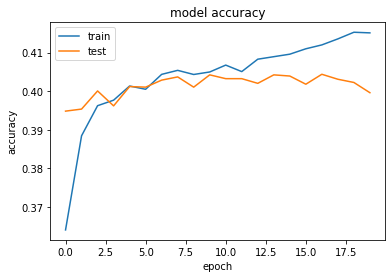

In [68]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('4b_accuracies.png')

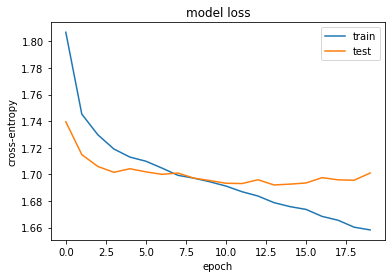

In [69]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('4c_losses.png')

In [76]:
keras.backend.clear_session()

model_dropout = Sequential()
model_dropout.add(Embedding(128,embed_dim,input_length = X.shape[1]))
model_dropout.add(Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same', kernel_regularizer=keras.regularizers.l1()))
model_dropout.add(LSTM(units=128, return_sequences=False))
model_dropout.add(Dense(9, activation='softmax'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            8192      
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            16416     
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 108,201
Trainable params: 108,201
Non-trainable params: 0
_________________________________________________________________


In [77]:
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 11s 19ms/step - loss: 2.3848 - accuracy: 0.3274 - val_loss: 1.8974 - val_accuracy: 0.3323
Epoch 2/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8988 - accuracy: 0.3283 - val_loss: 1.8941 - val_accuracy: 0.3323
Epoch 3/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8977 - accuracy: 0.3283 - val_loss: 1.8935 - val_accuracy: 0.3323
Epoch 4/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8978 - accuracy: 0.3283 - val_loss: 1.8935 - val_accuracy: 0.3323
Epoch 5/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8971 - accuracy: 0.3283 - val_loss: 1.8923 - val_accuracy: 0.3323
Epoch 6/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8960 - accuracy: 0.3283 - val_loss: 1.8917 - val_accuracy: 0.3323
Epoch 7/20
481/481 [==============================] - 8s 17ms/step - loss: 1.8965 - accuracy: 0.3283 - val_loss: 1.8921 - val_accuracy: 0.332

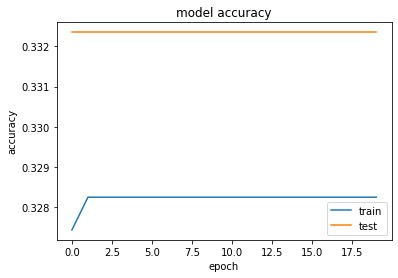

In [79]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('5b_accuracies.png')

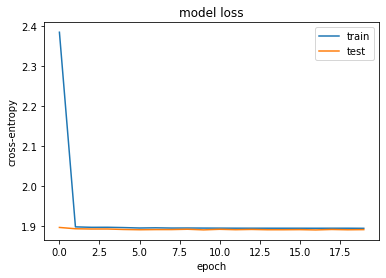

In [80]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('5c_losses.png')

In [89]:
from keras.layers import Layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [100]:
keras.backend.clear_session()
embed_dim = 8

inputs=Input((28,))
x=Embedding(128,embed_dim,input_length = X.shape[1],\
            embeddings_regularizer=keras.regularizers.l2(.001))(inputs)
att_in=LSTM(128,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=Dense(9,activation='softmax',trainable=True)(att_out)
model=keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding (Embedding)       (None, 28, 8)             1024      
                                                                 
 lstm (LSTM)                 (None, 28, 128)           70144     
                                                                 
 attention (attention)       (None, 128)               156       
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 72,485
Trainable params: 72,485
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [102]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 133s 269ms/step - loss: 1.8906 - accuracy: 0.3277 - val_loss: 1.8813 - val_accuracy: 0.3323
Epoch 2/20
481/481 [==============================] - 126s 263ms/step - loss: 1.8793 - accuracy: 0.3283 - val_loss: 1.8740 - val_accuracy: 0.3323
Epoch 3/20
481/481 [==============================] - 125s 261ms/step - loss: 1.8756 - accuracy: 0.3283 - val_loss: 1.8679 - val_accuracy: 0.3323
Epoch 4/20
481/481 [==============================] - 128s 266ms/step - loss: 1.8465 - accuracy: 0.3447 - val_loss: 1.8027 - val_accuracy: 0.3612
Epoch 5/20
481/481 [==============================] - 125s 261ms/step - loss: 1.7985 - accuracy: 0.3625 - val_loss: 1.7857 - val_accuracy: 0.3733
Epoch 6/20
481/481 [==============================] - 126s 261ms/step - loss: 1.7880 - accuracy: 0.3705 - val_loss: 1.7762 - val_accuracy: 0.3798
Epoch 7/20
481/481 [==============================] - 127s 264ms/step - loss: 1.7814 - accuracy: 0.3754 - val_loss: 1.7722 -

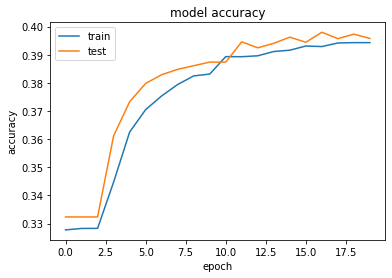

In [103]:
# plotting the accuracies for the training epochs
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('6b_accuracies.png')

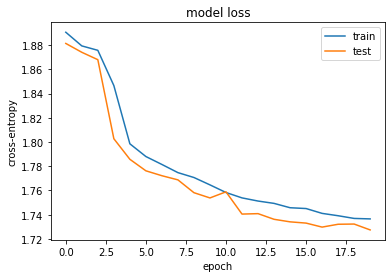

In [104]:
# plotting the losses for the training epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('6c_losses.png')

In [107]:
keras.backend.clear_session()
embed_dim = 8

inputs=Input((28,))
x=Embedding(128,embed_dim,input_length = X.shape[1],\
            embeddings_regularizer=keras.regularizers.l2(.001))(inputs)
att_in=LSTM(128,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_in_1=LSTM(128,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
outputs=Dense(9,activation='softmax',trainable=True)(att_out)
model=keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding (Embedding)       (None, 28, 8)             1024      
                                                                 
 lstm (LSTM)                 (None, 28, 128)           70144     
                                                                 
 lstm_1 (LSTM)               (None, 28, 128)           131584    
                                                                 
 attention (attention)       (None, 128)               156       
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 204,069
Trainable params: 204,069
Non-trainable

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
481/481 [==============================] - 238s 482ms/step - loss: 1.8867 - accuracy: 0.3263 - val_loss: 1.8821 - val_accuracy: 0.3323
Epoch 2/20
481/481 [==============================] - 234s 487ms/step - loss: 1.8781 - accuracy: 0.3282 - val_loss: 1.8788 - val_accuracy: 0.3323
Epoch 3/20
481/481 [==============================] - 237s 493ms/step - loss: 1.8613 - accuracy: 0.3375 - val_loss: 1.8217 - val_accuracy: 0.3636
Epoch 4/20
481/481 [==============================] - 236s 490ms/step - loss: 1.8045 - accuracy: 0.3632 - val_loss: 1.7843 - val_accuracy: 0.3728
Epoch 5/20
481/481 [==============================] - 238s 494ms/step - loss: 1.7865 - accuracy: 0.3712 - val_loss: 1.7753 - val_accuracy: 0.3752
Epoch 6/20
481/481 [==============================] - 231s 480ms/step - loss: 1.7823 - accuracy: 0.3752 - val_loss: 1.7768 - val_accuracy: 0.3772
Epoch 7/20
481/481 [==============================] - 231s 480ms/step - loss: 1.7779 - accuracy: 0.3779 - val_loss: 1.7651 -